In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [2]:
def get_cols(df: pd.DataFrame) -> tuple:
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

    return numeric_columns, categorical_columns

In [3]:
# df_train = pd.read_csv('../data/raw/train.csv')
# df_train.head()

In [4]:
# df_test = pd.read_csv('../data/raw/test.csv')
# df_test.head()

# *balances*

In [5]:
df_balances = (
    pd.read_csv('../data/raw/balances.csv')
    [['PERIODO','ID','CANT_EMP_NEG','CANT_EMP_CONS','CANT_EMP_HIPOT','SALDO_MED_EMP','SALDO_PEQ_EMP','SALDO_MIC_EMP','SALDO_CONS_REV','SALDO_CONS_NO_REV','SALDO_HIPOT','SALDO_VENCIDO']]
)

"""
PERIODO - Periodo de extracción de los datos
ID - Identificador único

CANT_EMP_NEG - Cantidad de empresas de negocio
CANT_EMP_CONS - Cantidad de empresas de consumo
CANT_EMP_HIPOT - Cantidad de empresas hipotecario
    * last
    * variable para ver si cerro o abrio empresas en los ultimos 9 meses

SALDO_MED_EMP - Saldo en mediana empresa
SALDO_PEQ_EMP - Saldo en pequeña empresa
SALDO_MIC_EMP - Saldo en micro empresa
    * categorica para saber que tipo de empresa tiene
    * last
    * variacion promedio de los saldos en los saldos que tiene

SALDO_CONS_REV - Saldo Consumo revolvente
SALDO_CONS_NO_REV - Saldo Consumo NO revolvente
    
SALDO_HIPOT - Saldo en hipotecario
SALDO_VENCIDO - Saldo vencido

CANT_EMP_DOL_NEG - Cantidad de empresas de negocios en dólares
SALDO_DOLA_NEG - Saldo en dólares de negocio
CANT_EMP_DOL_CONS - Cantidad de empresas de consumo en dólares
SALDO_DOLA_CONS - Saldo en dólares de consumo
CANT_EMP_DOL_HIPOT - Cantidad de empresas de hipotecario en dólares
SALDO_DOLA_HIPOT - Saldo en dólares de hipotecario
MAX_LINEA_DISP_U6M - Línea Máxima disponible en los últimos 6 meses
"""

df_balances.head(9*5)

,PERIODO,ID,CANT_EMP_NEG,CANT_EMP_CONS,CANT_EMP_HIPOT,SALDO_MED_EMP,SALDO_PEQ_EMP,SALDO_MIC_EMP,SALDO_CONS_REV,SALDO_CONS_NO_REV,SALDO_HIPOT,SALDO_VENCIDO
0,202301,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000
1,202302,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,427.860000,0.000000,0.000000,0.000000,0.000000
2,202303,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,349.490000,0.000000,0.000000,0.000000,0.000000
3,202304,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,269.120000,0.000000,0.000000,0.000000,0.000000
4,202305,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,183.880000,0.000000,0.000000,0.000000,0.000000
5,202306,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,94.460000,0.000000,0.000000,0.000000,0.000000
6,202307,8690c48cc637431889b9641da68f9284,1,1,0,0.000000,0.000000,1500.000000,0.000000,2200.050000,0.000000,0.000000
7,202308,8690c48cc637431889b9641da68f9284,1,1,0,0.000000,0.000000,1282.190000,0.000000,2200.050000,0.000000,0.000000
8,202309,8690c48cc637431889b9641da68f9284,1,1,0,0.000000,0.000000,1052.480000,0.000000,1952.470000,0.000000,0.000000
9,202301,5cc7873171464f8bb267b358c22b8961,1,0,0,0.000000,0.000000,3036.910000,0.000000,0.000000,0.000000,0.000000


In [6]:
df_balances['SALDO_EMP_TOTAL'] = df_balances['SALDO_MED_EMP'] + df_balances['SALDO_PEQ_EMP'] + df_balances['SALDO_MIC_EMP']

for col in ['SALDO_EMP_TOTAL', 'SALDO_PEQ_EMP', 'SALDO_MED_EMP', 'SALDO_MIC_EMP', 'SALDO_CONS_REV', 'SALDO_CONS_NO_REV', 'SALDO_HIPOT', 'SALDO_VENCIDO']:
    print(col)
    df_balances[f'VAR_{col}_1'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1))
    df_balances[f'VAR_{col}_MA3'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=3).mean())
    # df_balances[f'VAR_{col}_MA6'] = df_balances.groupby('ID')[f'{col}'].transform(lambda x: x.pct_change(periods=1).rolling(window=6).mean())
    
for col in ['SALDO_PEQ_EMP', 'SALDO_MED_EMP', 'SALDO_MIC_EMP'] + ['CANT_EMP_NEG', 'CANT_EMP_CONS', 'CANT_EMP_HIPOT']:
    print(col)
    df_balances[f'{col}_FLAG'] = df_balances[f'{col}'].apply(lambda x: True if x != 0 else False)

df_balances.head(9*10)

In [7]:
# df_balances.to_parquet('../data/processed/balances.gzip', compression='gzip')

In [8]:
# df_balances['PROXY_MOROSIDAD_1'] = df_balances['SALDO_VENCIDO'] / df_balances['SALDO_HIPOT']
# df_balances['PROXY_MOROSIDAD_2'] = df_balances['SALDO_VENCIDO'] / (df_balances['SALDO_CONS_REV'] + df_balances['SALDO_CONS_NO_REV'])

# df_balances['CANT_EMP_TOTAL'] = df_balances['CANT_EMP_NEG'] + df_balances['CANT_EMP_CONS'] + df_balances['CANT_EMP_HIPOT']    # ? las empresas son excluyentes?

In [9]:
# df_balances.head(50)

In [10]:
# list(df_balances['ID'].unique())

In [11]:
df_balances.describe()

,PERIODO,CANT_EMP_NEG,CANT_EMP_CONS,CANT_EMP_HIPOT,SALDO_MED_EMP,SALDO_PEQ_EMP,SALDO_MIC_EMP,SALDO_CONS_REV,SALDO_CONS_NO_REV,SALDO_HIPOT,SALDO_VENCIDO
count,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000,1367748.000000
mean,202305.000000,1.069871,0.831095,0.029990,2101.072579,16932.980005,3793.159801,1606.190205,6689.507745,6196.635288,1659.371244
std,2.581990,0.854740,1.100287,0.173273,48330.219369,40583.227017,12314.709994,7493.607441,53447.270146,59469.238302,16261.248787
min,202301.000000,0.000000,0.000000,0.000000,0.000000,-20329.880000,-1127.440000,0.000000,0.000000,0.000000,0.000000
25%,202303.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,202305.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,202307.000000,2.000000,1.000000,0.000000,0.000000,12390.312500,3005.492500,255.000000,2456.812500,0.000000,0.000000
max,202309.000000,10.000000,14.000000,3.000000,11594335.370000,2068056.760000,1707718.340000,434487.440000,17785456.000000,3054543.580000,2239703.480000


In [12]:
df_balances.loc[df_balances['ID'] == '5da41258ad18492ea3aac6cc6c1e7a32']

,PERIODO,ID,CANT_EMP_NEG,CANT_EMP_CONS,CANT_EMP_HIPOT,SALDO_MED_EMP,SALDO_PEQ_EMP,SALDO_MIC_EMP,SALDO_CONS_REV,SALDO_CONS_NO_REV,SALDO_HIPOT,SALDO_VENCIDO
378,202301,5da41258ad18492ea3aac6cc6c1e7a32,2,0,0,0.000000,174202.210000,0.000000,0.000000,0.000000,0.000000,0.000000
379,202302,5da41258ad18492ea3aac6cc6c1e7a32,2,0,0,0.000000,167531.270000,0.000000,0.000000,0.000000,0.000000,0.000000
380,202303,5da41258ad18492ea3aac6cc6c1e7a32,2,0,0,0.000000,212131.470000,0.000000,0.000000,0.000000,0.000000,0.000000
381,202304,5da41258ad18492ea3aac6cc6c1e7a32,2,1,0,0.000000,197860.340000,0.000000,2816.120000,0.000000,0.000000,0.000000
382,202305,5da41258ad18492ea3aac6cc6c1e7a32,2,1,0,0.000000,197860.340000,0.000000,2816.120000,0.000000,0.000000,0.000000
383,202306,5da41258ad18492ea3aac6cc6c1e7a32,2,1,0,0.000000,189821.680000,0.000000,2563.680000,0.000000,0.000000,0.000000
384,202307,5da41258ad18492ea3aac6cc6c1e7a32,2,1,0,0.000000,173303.440000,0.000000,2125.050000,0.000000,0.000000,0.000000
385,202308,5da41258ad18492ea3aac6cc6c1e7a32,2,1,0,0.000000,166008.950000,0.000000,1888.400000,0.000000,0.000000,0.000000
386,202309,5da41258ad18492ea3aac6cc6c1e7a32,2,1,0,0.000000,164972.220000,0.000000,1888.400000,0.000000,0.000000,0.000000


In [13]:
df_balances.dtypes

PERIODO                int64
ID                    object
CANT_EMP_NEG           int64
CANT_EMP_CONS          int64
CANT_EMP_HIPOT         int64
SALDO_MED_EMP        float64
SALDO_PEQ_EMP        float64
SALDO_MIC_EMP        float64
SALDO_CONS_REV       float64
SALDO_CONS_NO_REV    float64
SALDO_HIPOT          float64
SALDO_VENCIDO        float64
dtype: object

In [14]:
df_balances.groupby('ID').agg({'PERIODO': 'unique'})

,PERIODO
ID,
000029a662c546e3b1b4288c0ef44b91,"[202301, 202302, 202303, 202304, 202305, 20230..."
0000614a13a64391a0d0b795e10de445,"[202301, 202302, 202303, 202304, 202305, 20230..."
0000aa8cdc9c41e2abcdb1e574129657,"[202301, 202302, 202303, 202304, 202305, 20230..."
00013d9d5f8b4534928e8f1a86965063,"[202301, 202302, 202303, 202304, 202305, 20230..."
0001749326134f968516d75b20f9bd0d,"[202301, 202302, 202303, 202304, 202305, 20230..."
...,...
fffc7c9cb00542e7bf97af15db090b5e,"[202301, 202302, 202303, 202304, 202305, 20230..."
fffd54d91a7c4c8f9d79fb640eec3646,"[202301, 202302, 202303, 202304, 202305, 20230..."
fffd652dc6dc4f7d917f2820213af047,"[202301, 202302, 202303, 202304, 202305, 20230..."


(array([     0.,      0.,      0.,      0.,      0., 151972.,      0.,
             0.,      0.,      0.]),
 array([8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5]),
 <BarContainer object of 10 artists>)

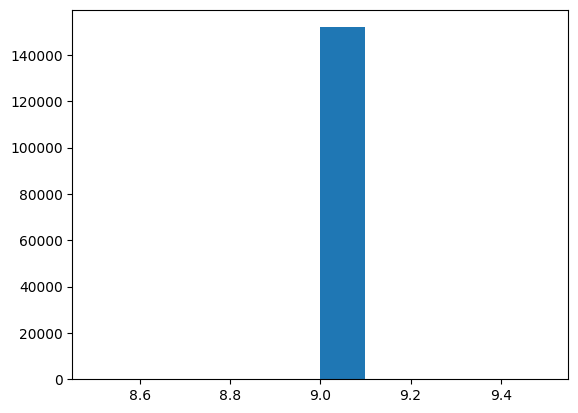

In [15]:
plt.hist(df_balances['ID'].value_counts().reset_index()['count'])

In [16]:
df_balances.isnull().sum() / len(df_balances)

PERIODO             0.000000
ID                  0.000000
CANT_EMP_NEG        0.000000
CANT_EMP_CONS       0.000000
CANT_EMP_HIPOT      0.000000
SALDO_MED_EMP       0.000000
SALDO_PEQ_EMP       0.000000
SALDO_MIC_EMP       0.000000
SALDO_CONS_REV      0.000000
SALDO_CONS_NO_REV   0.000000
SALDO_HIPOT         0.000000
SALDO_VENCIDO       0.000000
dtype: float64

<Axes: >

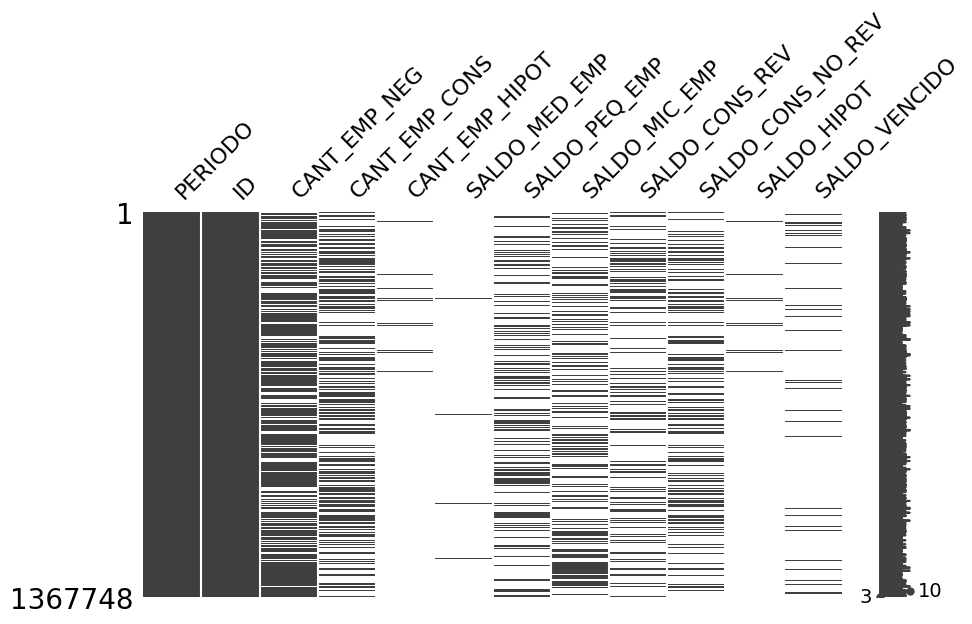

In [17]:
df_aux = df_balances.copy().replace(0, np.nan)
msno.matrix(df_aux, figsize=(10, 5))

In [20]:
df_balances = pd.read_parquet('../data/processed/balances.gzip')
df_balances.head(9*3)

,PERIODO,ID,CANT_EMP_NEG,CANT_EMP_CONS,CANT_EMP_HIPOT,SALDO_MED_EMP,SALDO_PEQ_EMP,SALDO_MIC_EMP,SALDO_CONS_REV,SALDO_CONS_NO_REV,SALDO_HIPOT,SALDO_VENCIDO,VAR_SALDO_PEQ_EMP_1,VAR_SALDO_PEQ_EMP_MA3,VAR_SALDO_PEQ_EMP_MA6,VAR_SALDO_MED_EMP_1,VAR_SALDO_MED_EMP_MA3,VAR_SALDO_MED_EMP_MA6,VAR_SALDO_MIC_EMP_1,VAR_SALDO_MIC_EMP_MA3,VAR_SALDO_MIC_EMP_MA6,VAR_SALDO_CONS_REV_1,VAR_SALDO_CONS_REV_MA3,VAR_SALDO_CONS_REV_MA6,VAR_SALDO_CONS_NO_REV_1,VAR_SALDO_CONS_NO_REV_MA3,VAR_SALDO_CONS_NO_REV_MA6,VAR_SALDO_HIPOT_1,VAR_SALDO_HIPOT_MA3,VAR_SALDO_HIPOT_MA6,VAR_SALDO_VENCIDO_1,VAR_SALDO_VENCIDO_MA3,VAR_SALDO_VENCIDO_MA6,SALDO_PEQ_EMP_FLAG,SALDO_MED_EMP_FLAG,SALDO_MIC_EMP_FLAG,CANT_EMP_NEG_FLAG,CANT_EMP_CONS_FLAG,CANT_EMP_HIPOT_FLAG
0,202301,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
1,202302,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,427.860000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.144280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
2,202303,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,349.490000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.183167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
3,202304,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,269.120000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.229964,-0.185804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
4,202305,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,183.880000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.316736,-0.243289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
5,202306,8690c48cc637431889b9641da68f9284,1,0,0,0.000000,0.000000,94.460000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.486295,-0.344332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False
6,202307,8690c48cc637431889b9641da68f9284,1,1,0,0.000000,0.000000,1500.000000,0.000000,2200.050000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,14.879737,4.692235,2.253216,NaN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,True,False
7,202308,8690c48cc637431889b9641da68f9284,1,1,0,0.000000,0.000000,1282.190000,0.000000,2200.050000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.145207,4.749412,2.253061,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,True,False
8,202309,8690c48cc637431889b9641da68f9284,1,1,0,0.000000,0.000000,1052.480000,0.000000,1952.470000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.179154,4.851792,2.253730,NaN,NaN,NaN,-0.112534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,True,False
9,202301,5cc7873171464f8bb267b358c22b8961,1,0,0,0.000000,0.000000,3036.910000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,False,False


In [21]:
df_balances.columns

Index(['PERIODO', 'ID', 'CANT_EMP_NEG', 'CANT_EMP_CONS', 'CANT_EMP_HIPOT',
       'SALDO_MED_EMP', 'SALDO_PEQ_EMP', 'SALDO_MIC_EMP', 'SALDO_CONS_REV',
       'SALDO_CONS_NO_REV', 'SALDO_HIPOT', 'SALDO_VENCIDO',
       'VAR_SALDO_PEQ_EMP_1', 'VAR_SALDO_PEQ_EMP_MA3', 'VAR_SALDO_PEQ_EMP_MA6',
       'VAR_SALDO_MED_EMP_1', 'VAR_SALDO_MED_EMP_MA3', 'VAR_SALDO_MED_EMP_MA6',
       'VAR_SALDO_MIC_EMP_1', 'VAR_SALDO_MIC_EMP_MA3', 'VAR_SALDO_MIC_EMP_MA6',
       'VAR_SALDO_CONS_REV_1', 'VAR_SALDO_CONS_REV_MA3',
       'VAR_SALDO_CONS_REV_MA6', 'VAR_SALDO_CONS_NO_REV_1',
       'VAR_SALDO_CONS_NO_REV_MA3', 'VAR_SALDO_CONS_NO_REV_MA6',
       'VAR_SALDO_HIPOT_1', 'VAR_SALDO_HIPOT_MA3', 'VAR_SALDO_HIPOT_MA6',
       'VAR_SALDO_VENCIDO_1', 'VAR_SALDO_VENCIDO_MA3', 'VAR_SALDO_VENCIDO_MA6',
       'SALDO_PEQ_EMP_FLAG', 'SALDO_MED_EMP_FLAG', 'SALDO_MIC_EMP_FLAG',
       'CANT_EMP_NEG_FLAG', 'CANT_EMP_CONS_FLAG', 'CANT_EMP_HIPOT_FLAG'],
      dtype='object')

In [27]:
df_balances_unirow = df_balances.groupby('ID').agg(
    {
        'CANT_EMP_NEG': ['max', 'last'],
        'CANT_EMP_CONS': ['max', 'last'],
        'CANT_EMP_HIPOT': ['max', 'last'],
        
        'SALDO_MED_EMP': ['mean', 'last', 'max', 'min'],
        'SALDO_PEQ_EMP': ['mean', 'last', 'max', 'min'],
        'SALDO_MIC_EMP': ['mean', 'last', 'max', 'min'],
        'SALDO_CONS_REV': ['mean', 'last', 'max', 'min'],
        'SALDO_CONS_NO_REV': ['mean', 'last', 'max', 'min'],
        'SALDO_HIPOT': ['mean', 'last', 'max', 'min'],
        'SALDO_VENCIDO': ['mean', 'last', 'max', 'min'],

        'VAR_SALDO_PEQ_EMP_1': ['mean'],
        'VAR_SALDO_PEQ_EMP_MA3': ['mean'],
        'VAR_SALDO_PEQ_EMP_MA6': ['mean'],
        'VAR_SALDO_MED_EMP_1': ['mean'],
        'VAR_SALDO_MED_EMP_MA3': ['mean'],
        'VAR_SALDO_MED_EMP_MA6': ['mean'],
        'VAR_SALDO_MIC_EMP_1': ['mean'],
        'VAR_SALDO_MIC_EMP_MA3': ['mean'],
        'VAR_SALDO_MIC_EMP_MA6': ['mean'],
        'VAR_SALDO_CONS_REV_1': ['mean'],
        'VAR_SALDO_CONS_REV_MA3': ['mean'],
        'VAR_SALDO_CONS_REV_MA6': ['mean'],
        'VAR_SALDO_CONS_NO_REV_1': ['mean'],
        'VAR_SALDO_CONS_NO_REV_MA3': ['mean'],
        'VAR_SALDO_CONS_NO_REV_MA6': ['mean'],
        'VAR_SALDO_HIPOT_1': ['mean'],
        'VAR_SALDO_HIPOT_MA3': ['mean'],
        'VAR_SALDO_HIPOT_MA6': ['mean'],
        'VAR_SALDO_VENCIDO_1': ['mean'],
        'VAR_SALDO_VENCIDO_MA3': ['mean'],
        'VAR_SALDO_VENCIDO_MA6': ['mean'],

        'SALDO_PEQ_EMP_FLAG' : ['any'],
        'SALDO_MED_EMP_FLAG' : ['any'],
        'SALDO_MIC_EMP_FLAG' : ['any'],
        'CANT_EMP_NEG_FLAG' : ['any'],
        'CANT_EMP_CONS_FLAG' : ['any'],
        'CANT_EMP_HIPOT_FLAG' : ['any'],
    }
).replace([np.inf, -np.inf], np.nan).fillna(0)

df_balances_unirow.columns = ['_'.join(col) for col in df_balances_unirow.columns.values]
df_balances_unirow = df_balances_unirow.reset_index()

df_balances_unirow

,ID,CANT_EMP_NEG_max,CANT_EMP_NEG_last,CANT_EMP_CONS_max,CANT_EMP_CONS_last,CANT_EMP_HIPOT_max,CANT_EMP_HIPOT_last,SALDO_MED_EMP_mean,SALDO_MED_EMP_last,SALDO_MED_EMP_max,SALDO_MED_EMP_min,SALDO_PEQ_EMP_mean,SALDO_PEQ_EMP_last,SALDO_PEQ_EMP_max,SALDO_PEQ_EMP_min,SALDO_MIC_EMP_mean,SALDO_MIC_EMP_last,SALDO_MIC_EMP_max,SALDO_MIC_EMP_min,SALDO_CONS_REV_mean,SALDO_CONS_REV_last,SALDO_CONS_REV_max,SALDO_CONS_REV_min,SALDO_CONS_NO_REV_mean,SALDO_CONS_NO_REV_last,SALDO_CONS_NO_REV_max,SALDO_CONS_NO_REV_min,SALDO_HIPOT_mean,SALDO_HIPOT_last,SALDO_HIPOT_max,SALDO_HIPOT_min,SALDO_VENCIDO_mean,SALDO_VENCIDO_last,SALDO_VENCIDO_max,SALDO_VENCIDO_min,VAR_SALDO_PEQ_EMP_1_mean,VAR_SALDO_PEQ_EMP_MA3_mean,VAR_SALDO_PEQ_EMP_MA6_mean,VAR_SALDO_MED_EMP_1_mean,VAR_SALDO_MED_EMP_MA3_mean,VAR_SALDO_MED_EMP_MA6_mean,VAR_SALDO_MIC_EMP_1_mean,VAR_SALDO_MIC_EMP_MA3_mean,VAR_SALDO_MIC_EMP_MA6_mean,VAR_SALDO_CONS_REV_1_mean,VAR_SALDO_CONS_REV_MA3_mean,VAR_SALDO_CONS_REV_MA6_mean,VAR_SALDO_CONS_NO_REV_1_mean,VAR_SALDO_CONS_NO_REV_MA3_mean,VAR_SALDO_CONS_NO_REV_MA6_mean,VAR_SALDO_HIPOT_1_mean,VAR_SALDO_HIPOT_MA3_mean,VAR_SALDO_HIPOT_MA6_mean,VAR_SALDO_VENCIDO_1_mean,VAR_SALDO_VENCIDO_MA3_mean,VAR_SALDO_VENCIDO_MA6_mean,SALDO_PEQ_EMP_FLAG_any,SALDO_MED_EMP_FLAG_any,SALDO_MIC_EMP_FLAG_any,CANT_EMP_NEG_FLAG_any,CANT_EMP_CONS_FLAG_any,CANT_EMP_HIPOT_FLAG_any
0,000029a662c546e3b1b4288c0ef44b91,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6063.746667,1361.590000,9974.500000,1361.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.145474,-0.090607,-0.090607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,True,True,False,False
1,0000614a13a64391a0d0b795e10de445,0,0,2,2,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,996.411111,814.810000,1367.420000,700.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,428.888889,820.000000,820.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.020633,-0.014699,-0.014699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,False,False,False,False,True,False
2,0000aa8cdc9c41e2abcdb1e574129657,1,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,18461.548889,23851.560000,31419.330000,0.000000,11416.682222,0.000000,35635.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.053551,0.000000,0.000000,0.000000,0.000000,-0.360099,-0.360099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True,False,True,True,False,False
3,00013d9d5f8b4534928e8f1a86965063,0,0,2,2,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33783.650000,32439.830000,45156.990000,21488.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047895,0.010728,0.010728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False,True,False
4,0001749326134f968516d75b20f9bd0d,0,0,3,3,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201.168889,0.000000,975.280000,0.000000,12719.743333,18753.230000,18753.230000,7615.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.416168,0.000000,0.000000,0.135469,0.091688,0.091688,0.000000,0.000000,0.000000,0.000000,0.00

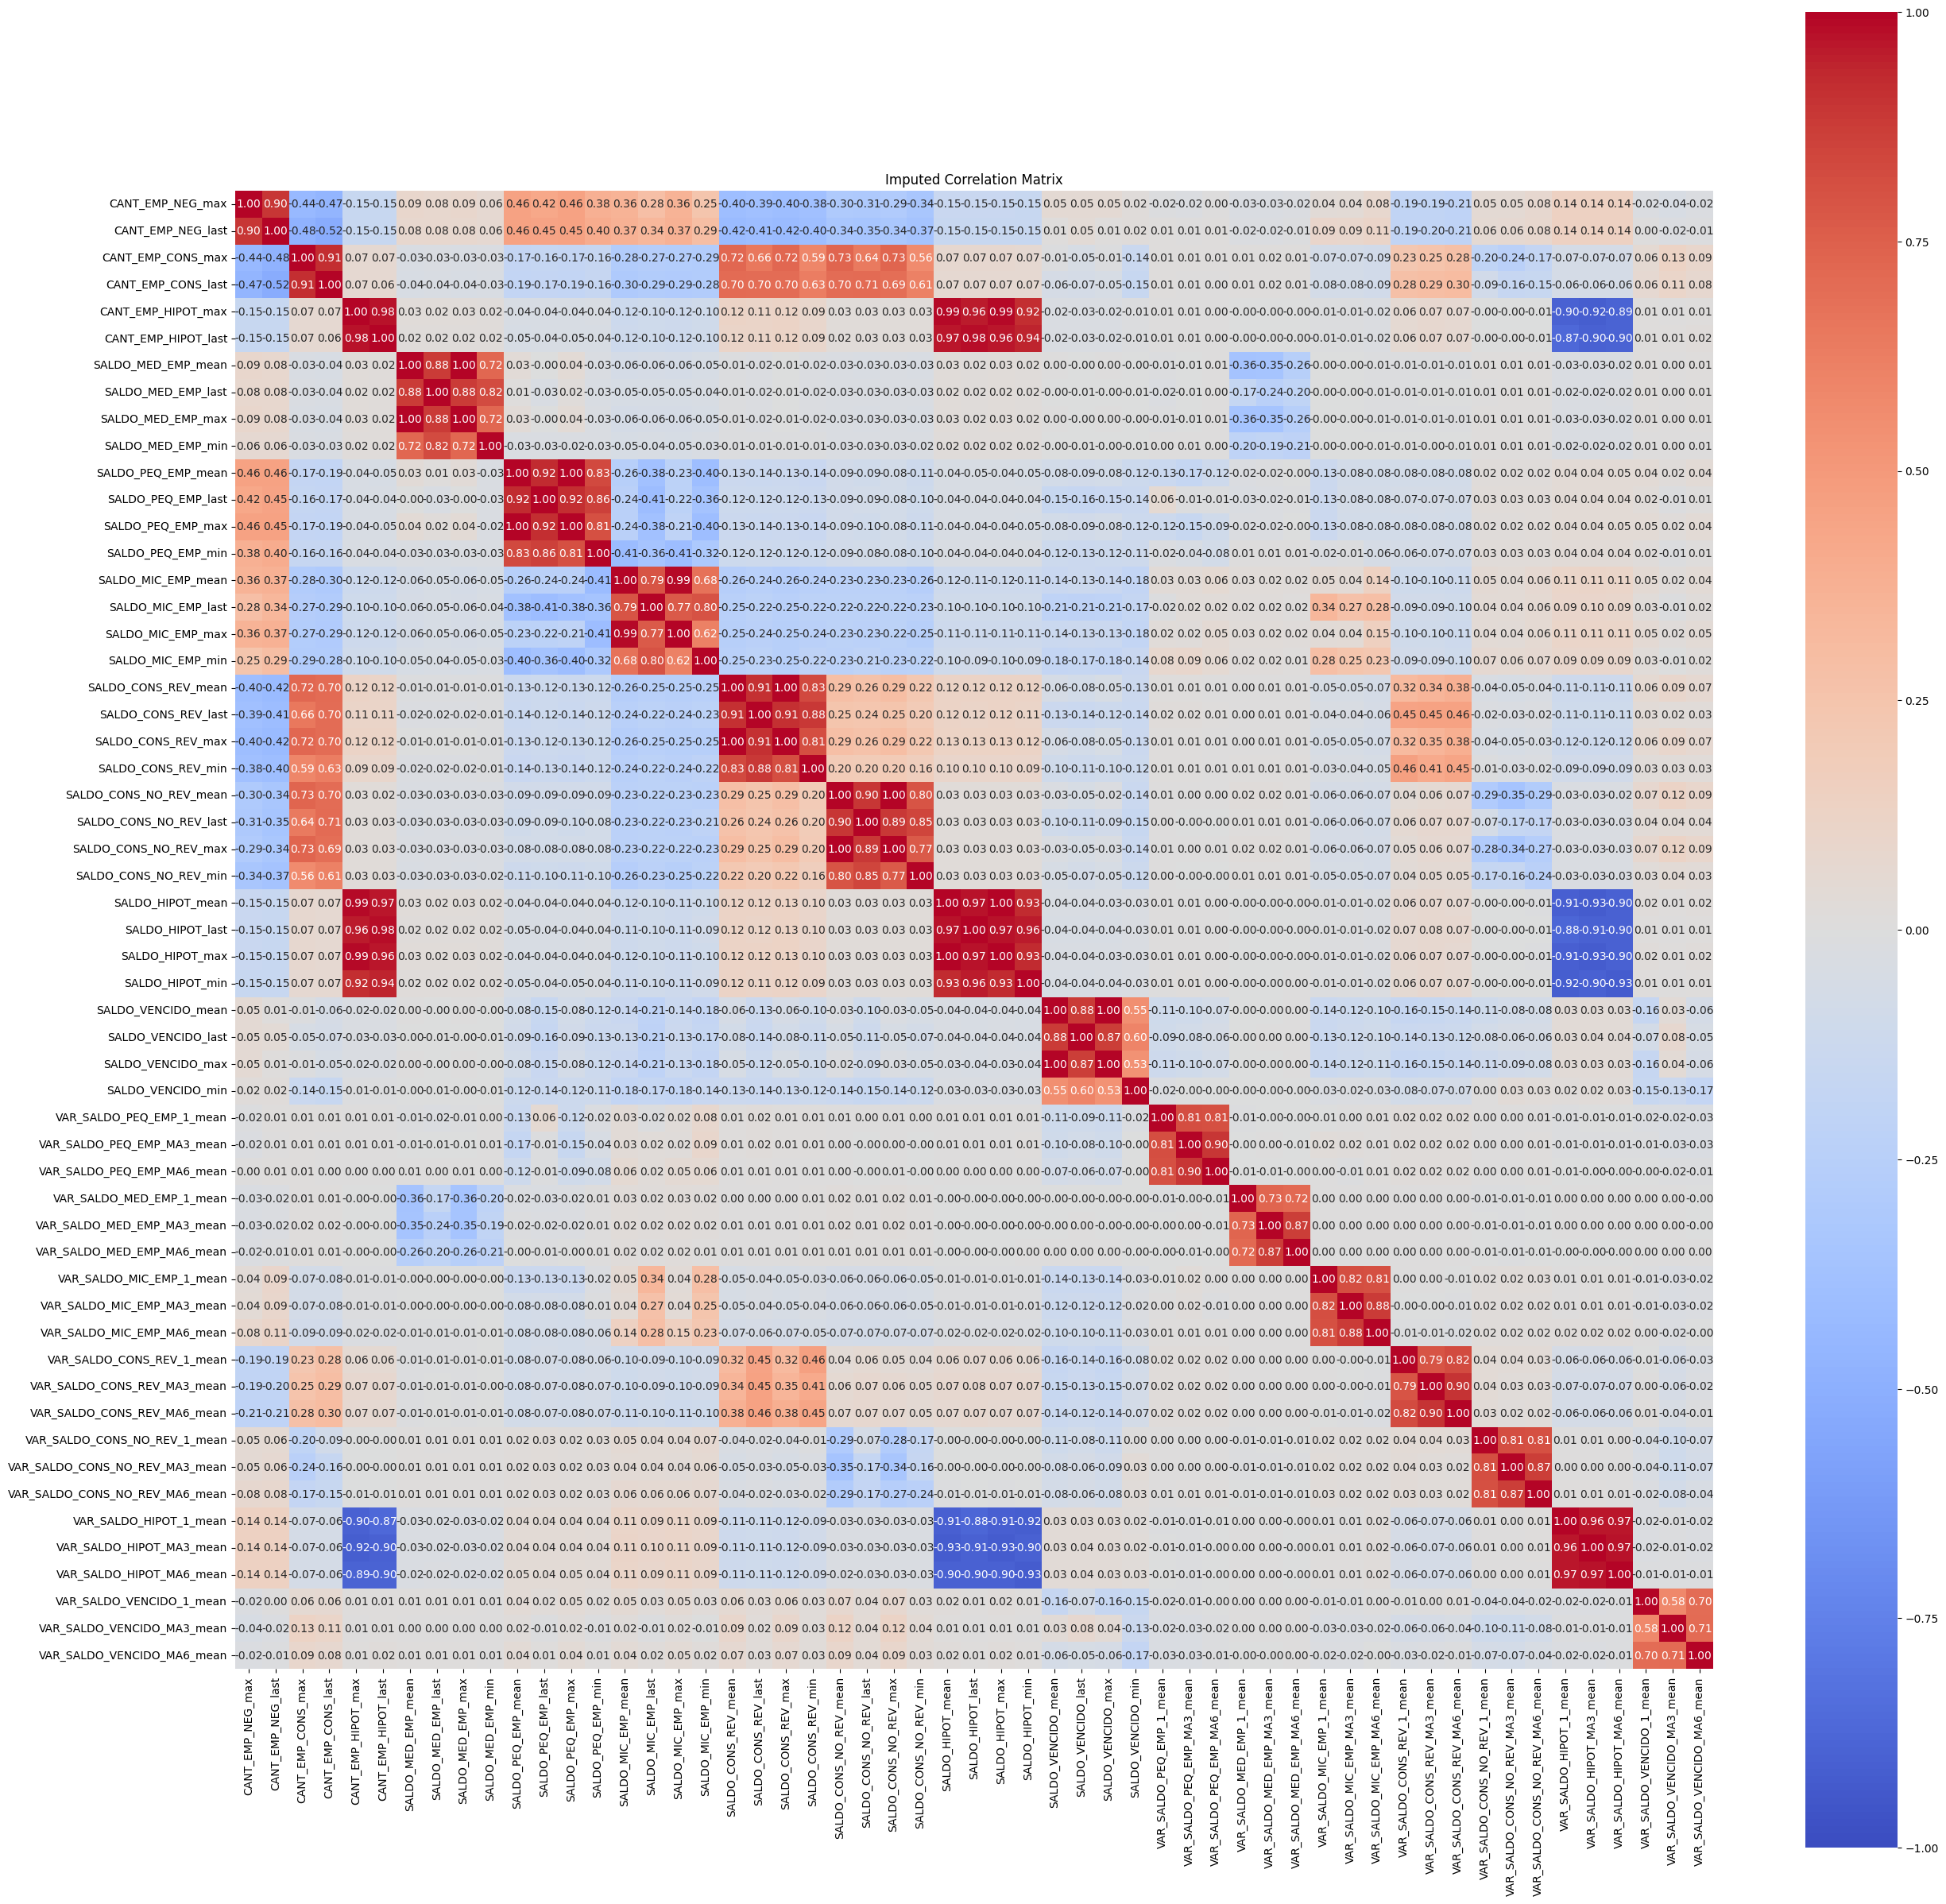

In [31]:
nc, cc = get_cols(df_balances_unirow)
# df_balances_unirow[nc].std().reset_index().sort_values(by=0, ascending=False)

corr_mat = df_balances_unirow[nc].corr(method='spearman')
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt='.2f')
plt.title('Imputed Correlation Matrix')
plt.show()

# *customers*

In [ ]:
df_customers = (
    pd.read_csv('../data/raw/customers.csv')
    .assign(
        PER_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].astype(str)
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[:4],
        MES_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[5:7]
    ).drop(columns=['PER_BANCARIZACION'])
)
df_customers

In [ ]:
df_customers.dtypes

In [ ]:
df_customers['CO_TIPO_SEXO'].value_counts(normalize=True)

In [ ]:
df_customers['NO_DEPARTAMENTO'].value_counts(normalize=True)
# * IDEA: Agrupar por regiones

In [ ]:
display(df_customers['DE_CIIU'].value_counts(normalize=True))

In [ ]:
msno.matrix(df_customers, figsize=(10, 5))